# Toxic Comments Classification - ML-Based Approach


1. Data Loading
2. Text Preprocessing (cleaning, stopwords, lemmatization)
3. Visualization (word frequencies, word clouds)
4. TF-IDF Feature Extraction
5. Model Training (Logistic Regression, SVM, Naive Bayes)
6. K-Fold Cross-Validation
7. Evaluation (Accuracy, F1-Macro, ROC-AUC)
8. Error Analysis

In [1]:
import pandas as pd
import numpy as np
import re
import string
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from datasets import load_dataset
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, 
    confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)
from scipy.sparse import save_npz, load_npz
import os
import warnings
warnings.filterwarnings('ignore')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords', quiet=True)
    
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet', quiet=True)
    
try:
    nltk.data.find('corpora/omw-1.4')
except LookupError:
    nltk.download('omw-1.4', quiet=True)

OUTPUT_DIR = '/media/relive/37c3bf4d-5cdc-450a-a045-97d5f9bc78961/project_z/outputs/ml_based'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print('Setup complete')

Setup complete


## 1. Load Dataset

In [2]:
print('Loading dataset...')
dataset = load_dataset('AiresPucrs/toxic-comments')

if 'train' in dataset:
    df = pd.DataFrame(dataset['train'])
else:
    split_name = list(dataset.keys())[0]
    df = pd.DataFrame(dataset[split_name])

print(f'Dataset shape: {df.shape}')
print(f'Columns: {df.columns.tolist()}')
df.head()

Loading dataset...
Dataset shape: (70157, 2)
Columns: ['comment_text', 'toxic']


,comment_text,toxic
0,explanation edits made username hardcore metal...,1
1,aww matches background colour seemingly stuck ...,1
2,hey man really trying edit war guy constantly ...,1
3,make real suggestions improvement wondered sec...,1
4,sir hero chance remember page,1


In [3]:
text_col = None
label_col = None

for col in df.columns:
    if 'text' in col.lower() or 'comment' in col.lower():
        text_col = col
    if 'label' in col.lower() or 'toxic' in col.lower():
        label_col = col

print(f'Text column: {text_col}')
print(f'Label column: {label_col}')

texts = df[text_col].astype(str).tolist()
labels = df[label_col].values

if len(labels.shape) > 1:
    labels = (labels.sum(axis=1) > 0).astype(int)

print(f'Total samples: {len(texts)}')
print(f'Label distribution: {np.unique(labels, return_counts=True)}')

Text column: comment_text
Label column: toxic
Total samples: 70157
Label distribution: (array([0, 1]), array([35080, 35077]))


## 2. Class Distribution Visualization

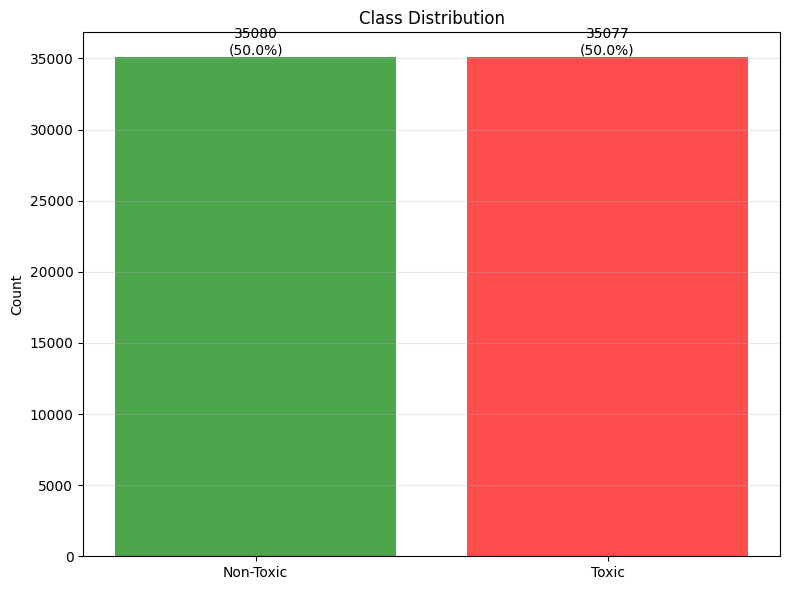

Saved: /media/relive/37c3bf4d-5cdc-450a-a045-97d5f9bc78961/project_z/outputs/ml_based/class_distribution.png


In [4]:
unique, counts = np.unique(labels, return_counts=True)

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(['Non-Toxic', 'Toxic'], counts, color=['green', 'red'], alpha=0.7)
ax.set_ylabel('Count')
ax.set_title('Class Distribution')
ax.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{int(height)}\n({height/sum(counts)*100:.1f}%)',
           ha='center', va='bottom')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print(f'Saved: {OUTPUT_DIR}/class_distribution.png')

## 3. Text Preprocessing

In [21]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

def lemmatize_text(text):
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

def preprocess_text(text):
    text = clean_text(text)
    text = remove_stopwords(text)
    text = lemmatize_text(text)
    return text

print("Preprocessing texts...")
processed_texts = [preprocess_text(text) for text in texts]

valid_indices = [i for i, t in enumerate(processed_texts) if len(t.strip()) > 0]
processed_texts = [processed_texts[i] for i in valid_indices]
labels = labels[valid_indices]

print(f"Processed {len(processed_texts)} valid texts")


print("\n Sample Before → After Cleaning ")
for i in range(10):
    print(f"\nOriginal: {texts[i]}")
    print(f"Cleaned : {processed_texts[i]}")


Preprocessing texts...
Processed 70157 valid texts

 Sample Before → After Cleaning 

Original: explanation edits made username hardcore metallica fan reverted vandalisms closure gas voted new york dolls fac please remove template talk page since retired
Cleaned : explanation edits made username hardcore metallica fan reverted vandalism closure gas voted new york doll fac please remove template talk page since retired

Original: aww matches background colour seemingly stuck thanks talk january utc
Cleaned : aww match background colour seemingly stuck thanks talk january utc

Original: hey man really trying edit war guy constantly removing relevant information talking edits instead talk page seems care formatting actual info
Cleaned : hey man really trying edit war guy constantly removing relevant information talking edits instead talk page seems care formatting actual info

Original: make real suggestions improvement wondered section statistics later subsection types accidents think re

## 4. Word Frequency Visualization

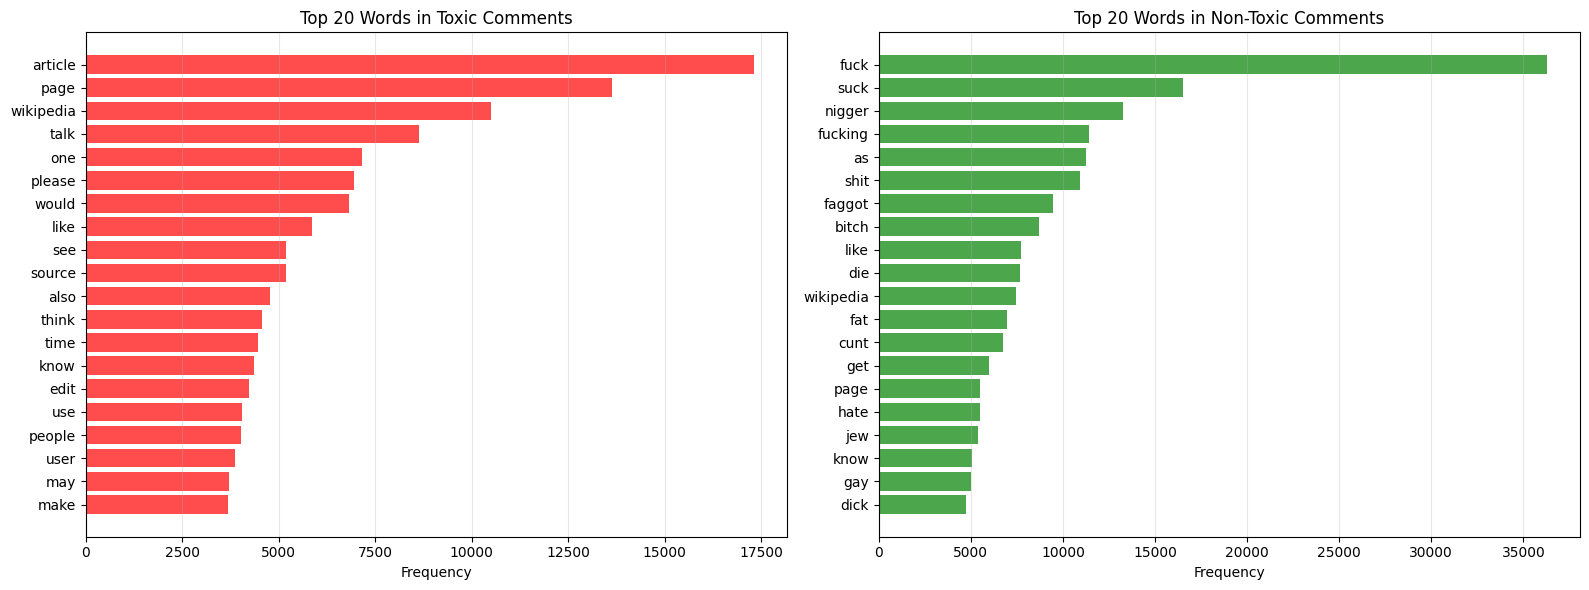

Saved: /media/relive/37c3bf4d-5cdc-450a-a045-97d5f9bc78961/project_z/outputs/ml_based/word_frequencies_barplot.png


In [6]:
toxic_texts = ' '.join([text for text, label in zip(processed_texts, labels) if label == 1])
non_toxic_texts = ' '.join([text for text, label in zip(processed_texts, labels) if label == 0])

toxic_words = Counter(toxic_texts.split())
non_toxic_words = Counter(non_toxic_texts.split())

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

top_n = 20
toxic_common = toxic_words.most_common(top_n)
words, counts = zip(*toxic_common)
axes[0].barh(range(len(words)), counts, color='red', alpha=0.7)
axes[0].set_yticks(range(len(words)))
axes[0].set_yticklabels(words)
axes[0].invert_yaxis()
axes[0].set_xlabel('Frequency')
axes[0].set_title(f'Top {top_n} Words in Toxic Comments')
axes[0].grid(axis='x', alpha=0.3)

non_toxic_common = non_toxic_words.most_common(top_n)
words, counts = zip(*non_toxic_common)
axes[1].barh(range(len(words)), counts, color='green', alpha=0.7)
axes[1].set_yticks(range(len(words)))
axes[1].set_yticklabels(words)
axes[1].invert_yaxis()
axes[1].set_xlabel('Frequency')
axes[1].set_title(f'Top {top_n} Words in Non-Toxic Comments')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/word_frequencies_barplot.png', dpi=300, bbox_inches='tight')
plt.show()
print(f'Saved: {OUTPUT_DIR}/word_frequencies_barplot.png')

## 5. Word Clouds

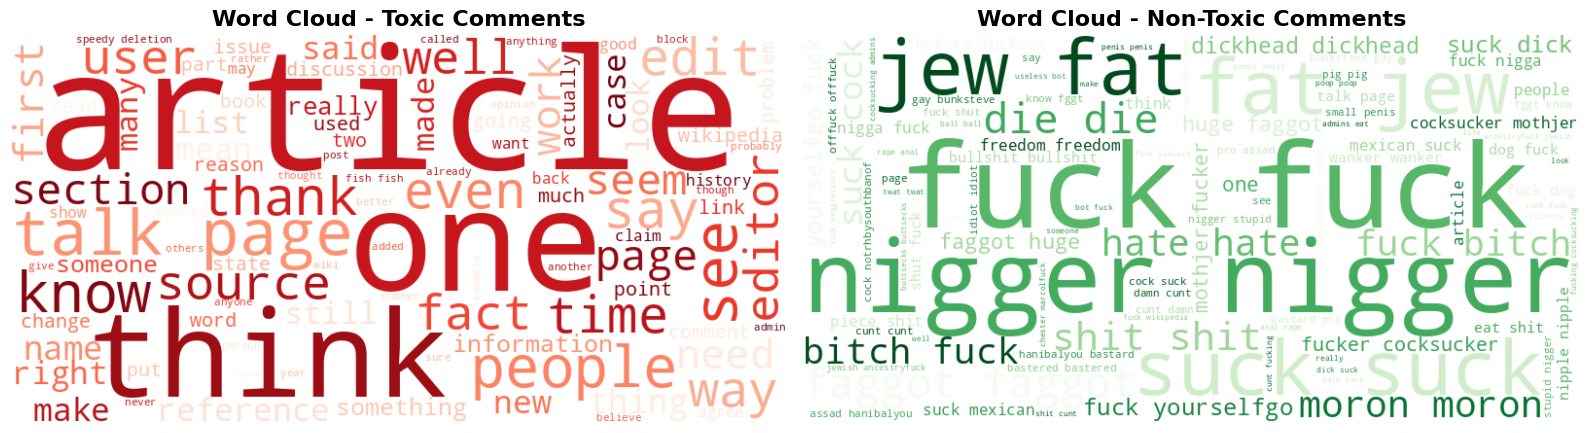

Saved: /media/relive/37c3bf4d-5cdc-450a-a045-97d5f9bc78961/project_z/outputs/ml_based/wordclouds.png


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

toxic_wordcloud = WordCloud(width=800, height=400, 
                             background_color='white',
                             colormap='Reds',
                             max_words=100).generate(toxic_texts)
axes[0].imshow(toxic_wordcloud, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Word Cloud - Toxic Comments', fontsize=16, fontweight='bold')

non_toxic_wordcloud = WordCloud(width=800, height=400,
                                 background_color='white',
                                 colormap='Greens',
                                 max_words=100).generate(non_toxic_texts)
axes[1].imshow(non_toxic_wordcloud, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Word Cloud - Non-Toxic Comments', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/wordclouds.png', dpi=300, bbox_inches='tight')
plt.show()
print(f'Saved: {OUTPUT_DIR}/wordclouds.png')

## 6. TF-IDF Feature Extraction

In [8]:
print('Extracting TF-IDF features...')
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9
)

tfidf_features = tfidf_vectorizer.fit_transform(processed_texts)
print(f'TF-IDF feature shape: {tfidf_features.shape}')

Extracting TF-IDF features...
TF-IDF feature shape: (70157, 5000)


## 7. TF-IDF Top Features Visualization

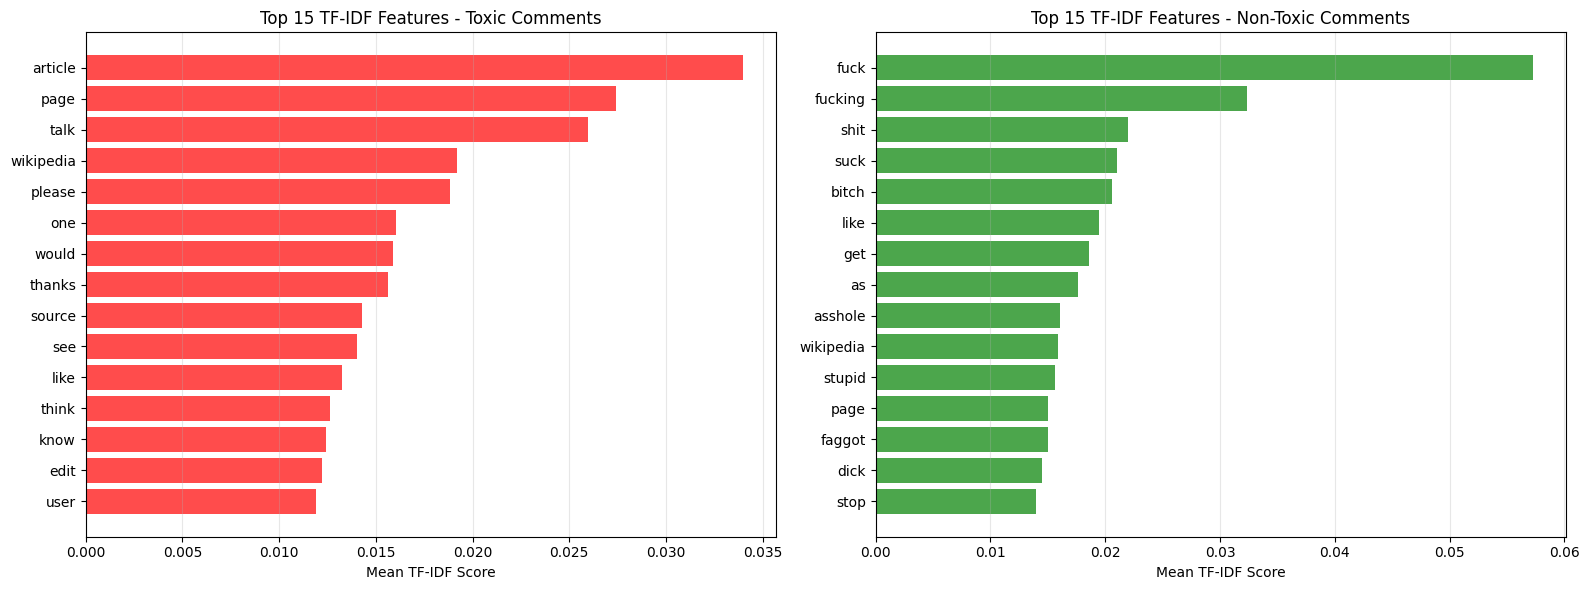

Saved: /media/relive/37c3bf4d-5cdc-450a-a045-97d5f9bc78961/project_z/outputs/ml_based/tfidf_top_features.png


In [9]:
feature_names = tfidf_vectorizer.get_feature_names_out()

toxic_mask = labels == 1
non_toxic_mask = labels == 0

toxic_mean = np.asarray(tfidf_features[toxic_mask].mean(axis=0)).flatten()
non_toxic_mean = np.asarray(tfidf_features[non_toxic_mask].mean(axis=0)).flatten()

top_n = 15
toxic_top_indices = toxic_mean.argsort()[-top_n:][::-1]
non_toxic_top_indices = non_toxic_mean.argsort()[-top_n:][::-1]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

toxic_features = [feature_names[i] for i in toxic_top_indices]
toxic_scores = [toxic_mean[i] for i in toxic_top_indices]
axes[0].barh(range(len(toxic_features)), toxic_scores, color='red', alpha=0.7)
axes[0].set_yticks(range(len(toxic_features)))
axes[0].set_yticklabels(toxic_features)
axes[0].invert_yaxis()
axes[0].set_xlabel('Mean TF-IDF Score')
axes[0].set_title(f'Top {top_n} TF-IDF Features - Toxic Comments')
axes[0].grid(axis='x', alpha=0.3)

non_toxic_features = [feature_names[i] for i in non_toxic_top_indices]
non_toxic_scores = [non_toxic_mean[i] for i in non_toxic_top_indices]
axes[1].barh(range(len(non_toxic_features)), non_toxic_scores, color='green', alpha=0.7)
axes[1].set_yticks(range(len(non_toxic_features)))
axes[1].set_yticklabels(non_toxic_features)
axes[1].invert_yaxis()
axes[1].set_xlabel('Mean TF-IDF Score')
axes[1].set_title(f'Top {top_n} TF-IDF Features - Non-Toxic Comments')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/tfidf_top_features.png', dpi=300, bbox_inches='tight')
plt.show()
print(f'Saved: {OUTPUT_DIR}/tfidf_top_features.png')

## 8. Train/Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    tfidf_features, labels, 
    test_size=0.2, 
    random_state=42, 
    stratify=labels
)

print(f'Training set: {X_train.shape[0]} samples')
print(f'Test set: {X_test.shape[0]} samples')
print(f'Toxic ratio in train: {y_train.mean():.2%}')
print(f'Toxic ratio in test: {y_test.mean():.2%}')

save_npz(f'{OUTPUT_DIR}/X_train.npz', X_train)
save_npz(f'{OUTPUT_DIR}/X_test.npz', X_test)
np.save(f'{OUTPUT_DIR}/y_train.npy', y_train)
np.save(f'{OUTPUT_DIR}/y_test.npy', y_test)

train_indices, test_indices = train_test_split(
    range(len(processed_texts)), 
    test_size=0.2, 
    random_state=42, 
    stratify=labels
)

train_texts = [processed_texts[i] for i in train_indices]
test_texts = [processed_texts[i] for i in test_indices]

pd.DataFrame({'text': train_texts, 'label': y_train}).to_csv(f'{OUTPUT_DIR}/train_texts.csv', index=False)
pd.DataFrame({'text': test_texts, 'label': y_test}).to_csv(f'{OUTPUT_DIR}/test_texts.csv', index=False)

print('Data saved successfully')

Training set: 56125 samples
Test set: 14032 samples
Toxic ratio in train: 50.00%
Toxic ratio in test: 50.00%
Data saved successfully


## 9. Initialize Models

In [11]:
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, 
        random_state=42,
        class_weight='balanced',
        C=1.0
    ),
    'Linear SVM': LinearSVC(
        max_iter=1000,
        random_state=42,
        class_weight='balanced',
        C=1.0
    ),
    'Naive Bayes': MultinomialNB(alpha=1.0)
}

print(f'Initialized {len(models)} models: {list(models.keys())}')

Initialized 3 models: ['Logistic Regression', 'Linear SVM', 'Naive Bayes']


## 10. K-Fold Cross-Validation

In [12]:
cv_results = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    print(f'\n{model_name}:')
    print('-' * 50)
    
    cv_accuracy = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)
    cv_f1 = cross_val_score(model, X_train, y_train, cv=skf, scoring='f1_macro', n_jobs=-1)
    cv_roc_auc = cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1)
    
    print(f'  Accuracy:  {cv_accuracy.mean():.4f} (+/- {cv_accuracy.std():.4f})')
    print(f'  F1-Macro:  {cv_f1.mean():.4f} (+/- {cv_f1.std():.4f})')
    print(f'  ROC-AUC:   {cv_roc_auc.mean():.4f} (+/- {cv_roc_auc.std():.4f})')
    
    cv_results.append({
        'Model': model_name,
        'CV_Accuracy': cv_accuracy.mean(),
        'CV_Accuracy_Std': cv_accuracy.std(),
        'CV_F1_Macro': cv_f1.mean(),
        'CV_F1_Macro_Std': cv_f1.std(),
        'CV_ROC_AUC': cv_roc_auc.mean(),
        'CV_ROC_AUC_Std': cv_roc_auc.std()
    })

cv_df = pd.DataFrame(cv_results)
cv_df.to_csv(f'{OUTPUT_DIR}/cross_validation_results.csv', index=False)
print(f'\nSaved: {OUTPUT_DIR}/cross_validation_results.csv')
cv_df


Logistic Regression:
--------------------------------------------------
  Accuracy:  0.9258 (+/- 0.0019)
  F1-Macro:  0.9257 (+/- 0.0019)
  ROC-AUC:   0.9793 (+/- 0.0015)

Linear SVM:
--------------------------------------------------
  Accuracy:  0.9325 (+/- 0.0010)
  F1-Macro:  0.9324 (+/- 0.0010)
  ROC-AUC:   0.9799 (+/- 0.0011)

Naive Bayes:
--------------------------------------------------
  Accuracy:  0.9039 (+/- 0.0020)
  F1-Macro:  0.9039 (+/- 0.0020)
  ROC-AUC:   0.9652 (+/- 0.0016)

Saved: /media/relive/37c3bf4d-5cdc-450a-a045-97d5f9bc78961/project_z/outputs/ml_based/cross_validation_results.csv


,Model,CV_Accuracy,CV_Accuracy_Std,CV_F1_Macro,CV_F1_Macro_Std,CV_ROC_AUC,CV_ROC_AUC_Std
0,Logistic Regression,0.925773,0.001895,0.925705,0.001899,0.979279,0.001538
1,Linear SVM,0.932472,0.000956,0.932449,0.000957,0.979934,0.001077
2,Naive Bayes,0.903857,0.001960,0.903857,0.001961,0.965234,0.001591


## 11. Train and Evaluate on Test Set

In [13]:
test_results = []
predictions = {}

for model_name, model in models.items():
    print(f'\n{model_name}:')
    print('-' * 50)
    
    print('  Training...')
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, 'decision_function'):
        y_pred_proba = model.decision_function(X_test)
    else:
        y_pred_proba = y_pred
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f'  Accuracy:  {accuracy:.4f}')
    print(f'  F1-Macro:  {f1:.4f}')
    print(f'  ROC-AUC:   {roc_auc:.4f}')
    
    test_results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'F1_Macro': f1,
        'ROC_AUC': roc_auc
    })
    
    predictions[model_name] = {
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'y_test': y_test
    }

test_df = pd.DataFrame(test_results)
test_df.to_csv(f'{OUTPUT_DIR}/test_results.csv', index=False)
print(f'\nSaved: {OUTPUT_DIR}/test_results.csv')
test_df


Logistic Regression:
--------------------------------------------------
  Training...
  Accuracy:  0.9287
  F1-Macro:  0.9286
  ROC-AUC:   0.9813

Linear SVM:
--------------------------------------------------
  Training...
  Accuracy:  0.9354
  F1-Macro:  0.9354
  ROC-AUC:   0.9822

Naive Bayes:
--------------------------------------------------
  Training...
  Accuracy:  0.9022
  F1-Macro:  0.9022
  ROC-AUC:   0.9655

Saved: /media/relive/37c3bf4d-5cdc-450a-a045-97d5f9bc78961/project_z/outputs/ml_based/test_results.csv


,Model,Accuracy,F1_Macro,ROC_AUC
0,Logistic Regression,0.928663,0.928609,0.981264
1,Linear SVM,0.935362,0.935351,0.982215
2,Naive Bayes,0.902223,0.902223,0.965494


## 12. Model Comparison Visualization

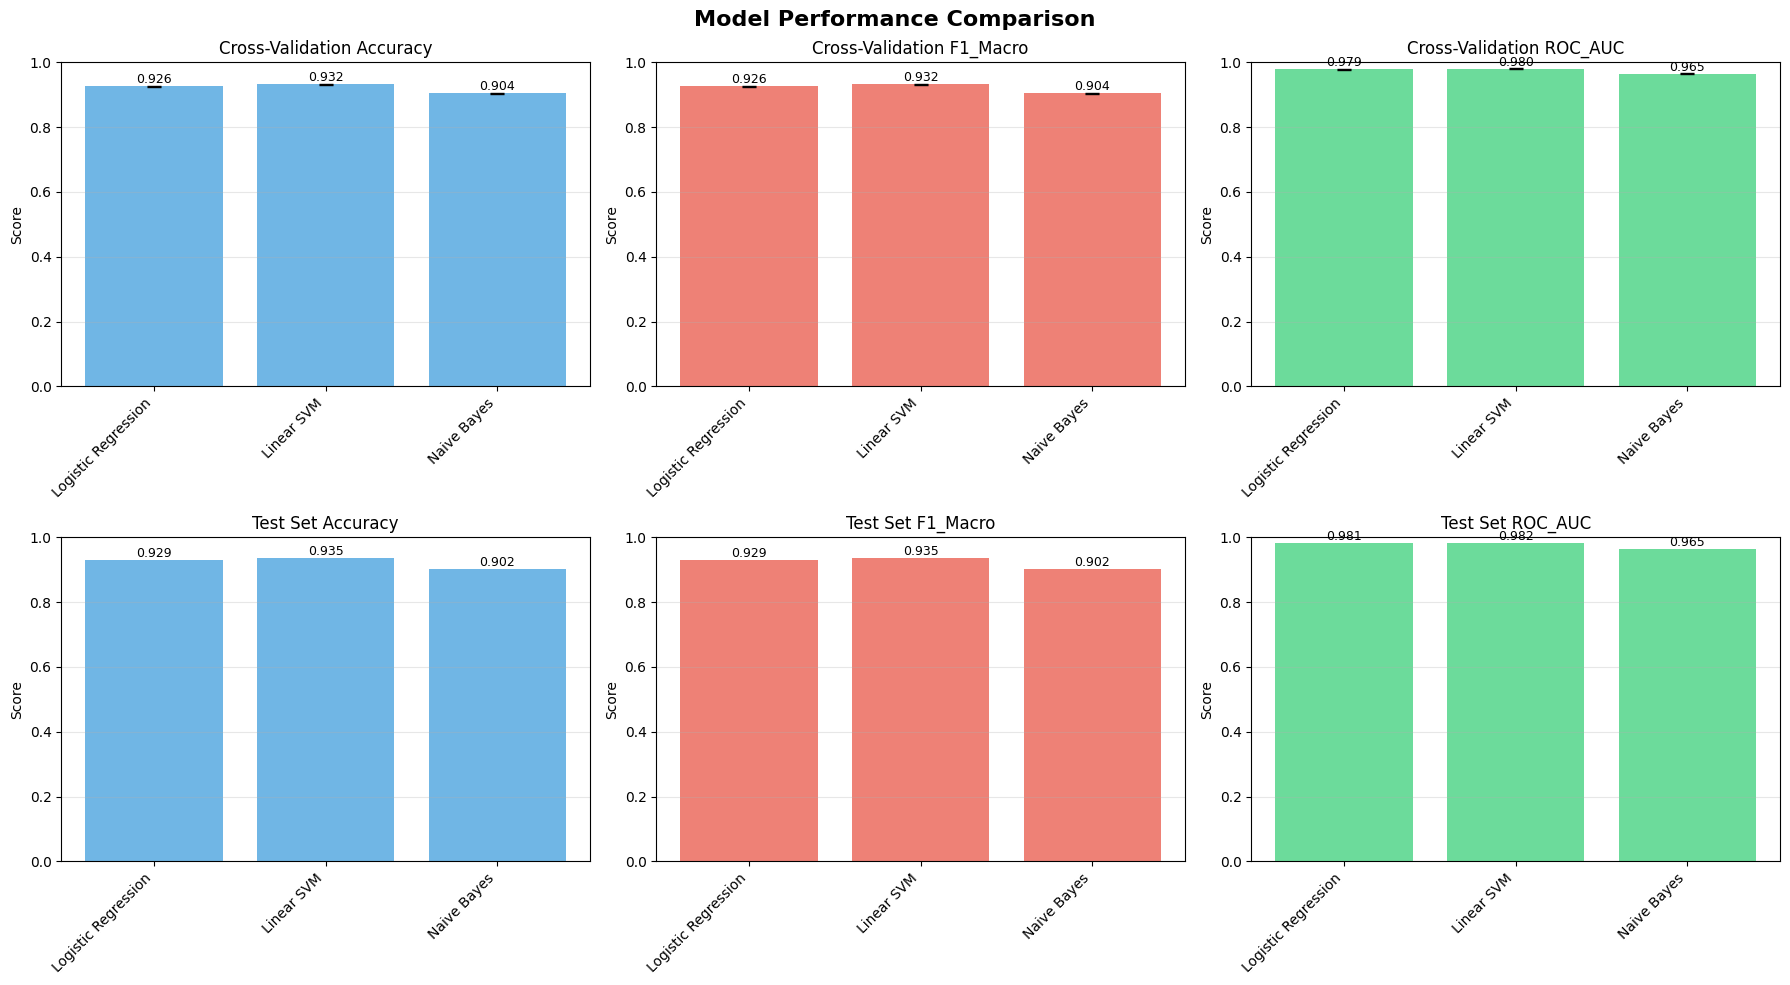

Saved: /media/relive/37c3bf4d-5cdc-450a-a045-97d5f9bc78961/project_z/outputs/ml_based/model_comparison.png


In [14]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

metrics = ['Accuracy', 'F1_Macro', 'ROC_AUC']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for idx, metric in enumerate(metrics):
    ax = axes[0, idx]
    cv_col = f'CV_{metric}'
    cv_std_col = f'CV_{metric}_Std'
    
    bars = ax.bar(cv_df['Model'], cv_df[cv_col], 
                 yerr=cv_df[cv_std_col], capsize=5,
                 color=colors[idx], alpha=0.7)
    ax.set_ylabel('Score')
    ax.set_title(f'Cross-Validation {metric}')
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.3f}', ha='center', va='bottom', fontsize=9)

for idx, metric in enumerate(metrics):
    ax = axes[1, idx]
    bars = ax.bar(test_df['Model'], test_df[metric], 
                 color=colors[idx], alpha=0.7)
    ax.set_ylabel('Score')
    ax.set_title(f'Test Set {metric}')
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print(f'Saved: {OUTPUT_DIR}/model_comparison.png')

## 13. Confusion Matrices

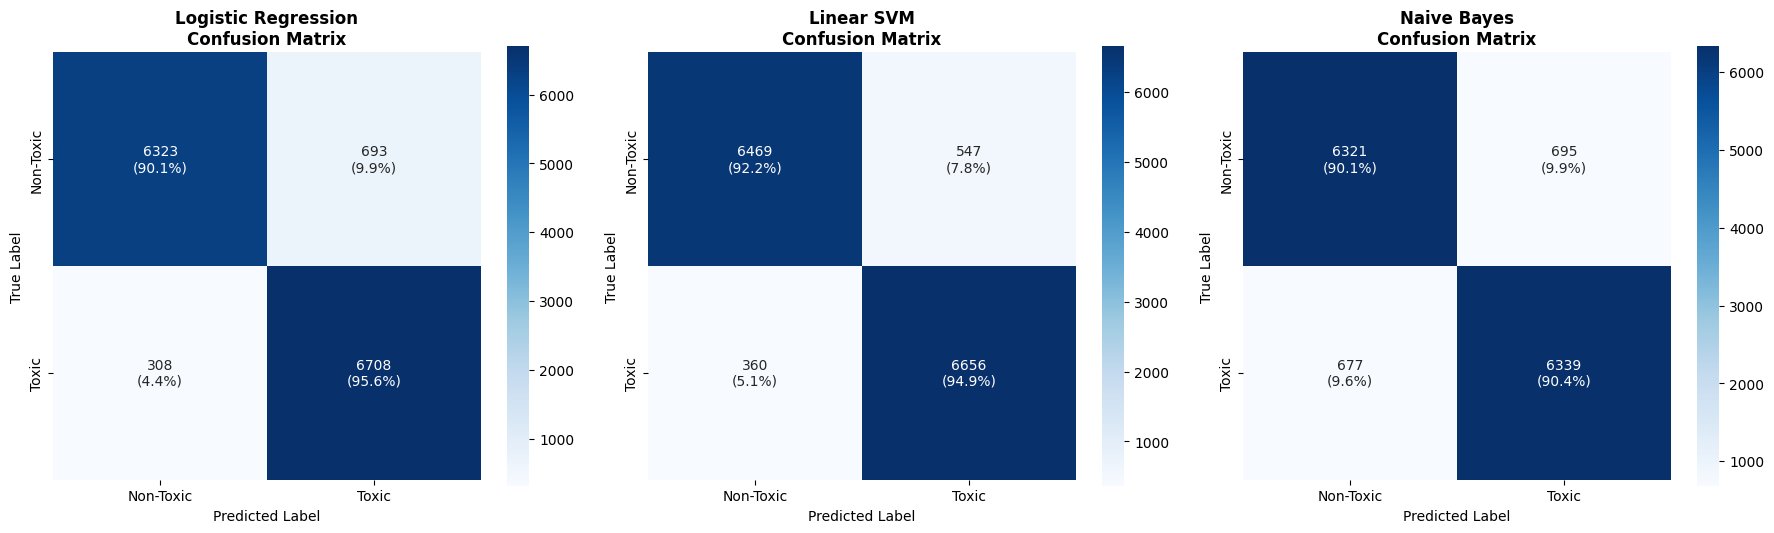

Saved: /media/relive/37c3bf4d-5cdc-450a-a045-97d5f9bc78961/project_z/outputs/ml_based/confusion_matrices.png


In [15]:
n_models = len(predictions)
fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))

if n_models == 1:
    axes = [axes]

for idx, (model_name, preds) in enumerate(predictions.items()):
    cm = confusion_matrix(preds['y_test'], preds['y_pred'])
    
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    annotations = np.empty_like(cm, dtype=object)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annotations[i, j] = f'{cm[i, j]}\n({cm_percent[i, j]:.1f}%)'
    
    sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues', 
               cbar=True, square=True, ax=axes[idx],
               xticklabels=['Non-Toxic', 'Toxic'],
               yticklabels=['Non-Toxic', 'Toxic'])
    axes[idx].set_title(f'{model_name}\nConfusion Matrix', fontweight='bold')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()
print(f'Saved: {OUTPUT_DIR}/confusion_matrices.png')

## 14. ROC Curves

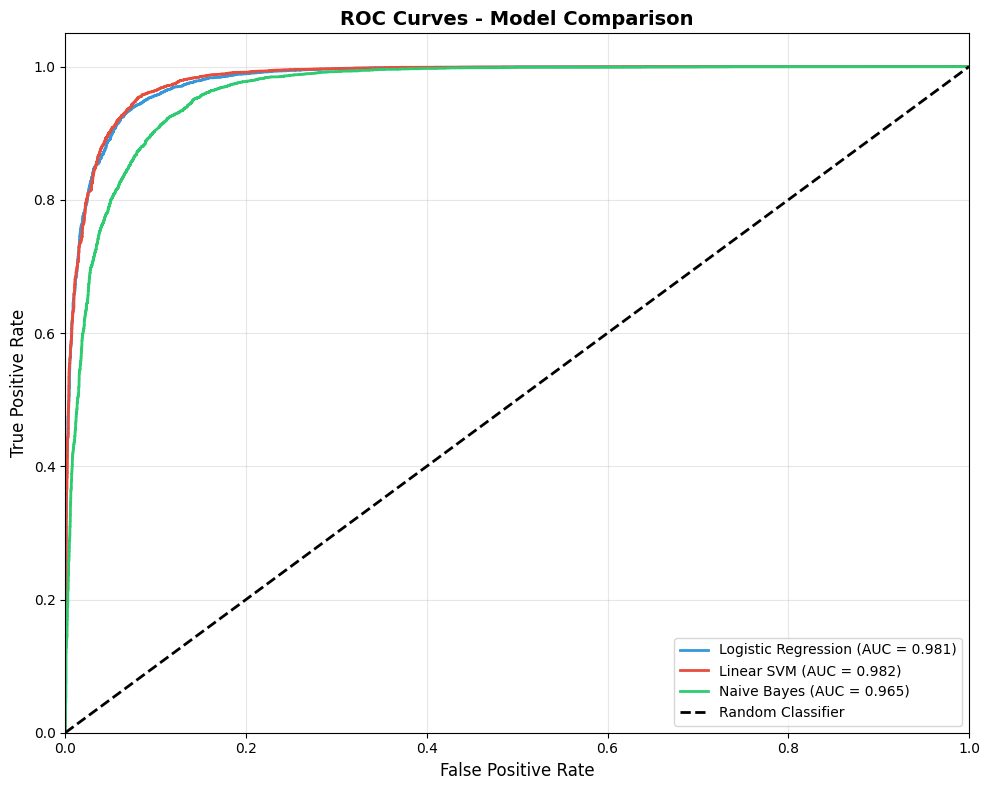

Saved: /media/relive/37c3bf4d-5cdc-450a-a045-97d5f9bc78961/project_z/outputs/ml_based/roc_curves.png


In [16]:
plt.figure(figsize=(10, 8))

colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

for idx, (model_name, preds) in enumerate(predictions.items()):
    fpr, tpr, _ = roc_curve(preds['y_test'], preds['y_pred_proba'])
    auc = roc_auc_score(preds['y_test'], preds['y_pred_proba'])
    
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})',
            linewidth=2, color=colors[idx % len(colors)])

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print(f'Saved: {OUTPUT_DIR}/roc_curves.png')

## 15. Precision-Recall Curves

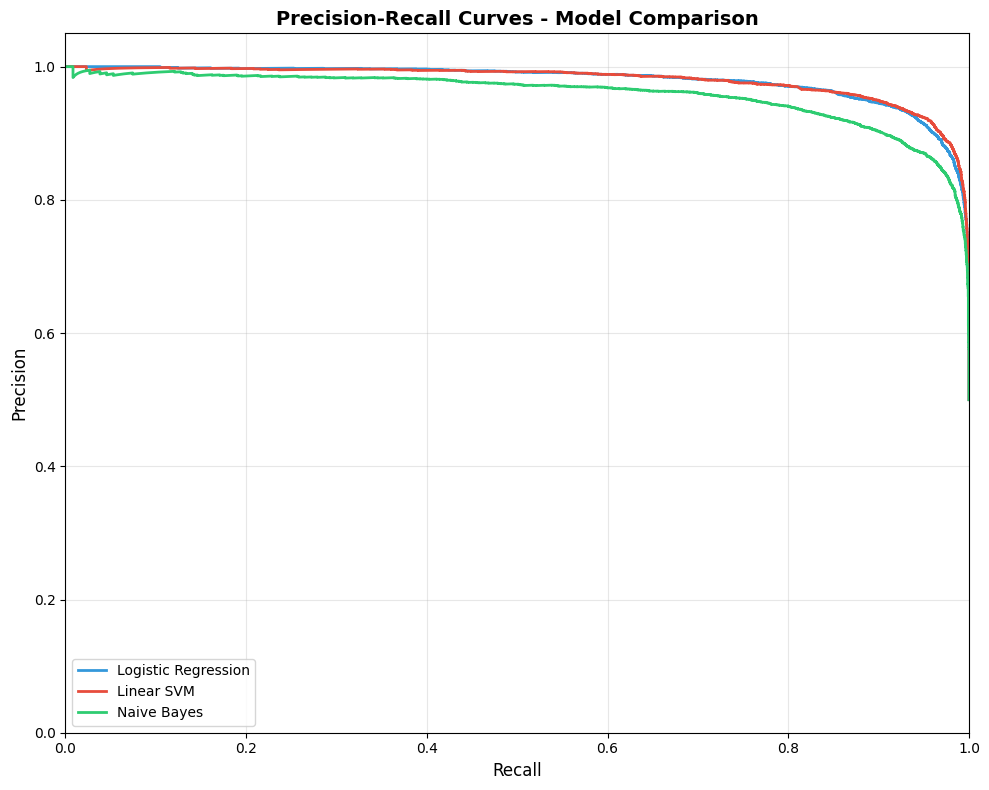

Saved: /media/relive/37c3bf4d-5cdc-450a-a045-97d5f9bc78961/project_z/outputs/ml_based/precision_recall_curves.png


In [17]:
plt.figure(figsize=(10, 8))

colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

for idx, (model_name, preds) in enumerate(predictions.items()):
    precision, recall, _ = precision_recall_curve(preds['y_test'], preds['y_pred_proba'])
    
    plt.plot(recall, precision, label=model_name,
            linewidth=2, color=colors[idx % len(colors)])

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/precision_recall_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print(f'Saved: {OUTPUT_DIR}/precision_recall_curves.png')

## 16. Error Analysis

In [18]:
test_texts_df = pd.read_csv(f'{OUTPUT_DIR}/test_texts.csv')

error_analysis_results = []

for model_name, preds in predictions.items():
    y_test_curr = preds['y_test']
    y_pred = preds['y_pred']
    
    misclassified_mask = y_test_curr != y_pred
    
    fp_mask = (y_pred == 1) & (y_test_curr == 0)
    fp_count = fp_mask.sum()
    
    fn_mask = (y_pred == 0) & (y_test_curr == 1)
    fn_count = fn_mask.sum()
    
    error_analysis_results.append({
        'Model': model_name,
        'Total_Errors': misclassified_mask.sum(),
        'False_Positives': fp_count,
        'False_Negatives': fn_count,
        'Error_Rate': misclassified_mask.mean()
    })
    
    if len(test_texts_df) == len(y_test_curr):
        fp_examples = test_texts_df[fp_mask].head(10)
        fn_examples = test_texts_df[fn_mask].head(10)
        
        fp_examples.to_csv(f'{OUTPUT_DIR}/{model_name.replace(" ", "_")}_false_positives.csv', index=False)
        fn_examples.to_csv(f'{OUTPUT_DIR}/{model_name.replace(" ", "_")}_false_negatives.csv', index=False)

error_df = pd.DataFrame(error_analysis_results)
error_df.to_csv(f'{OUTPUT_DIR}/error_analysis_summary.csv', index=False)
print(f'Saved: {OUTPUT_DIR}/error_analysis_summary.csv')
error_df

Saved: /media/relive/37c3bf4d-5cdc-450a-a045-97d5f9bc78961/project_z/outputs/ml_based/error_analysis_summary.csv


,Model,Total_Errors,False_Positives,False_Negatives,Error_Rate
0,Logistic Regression,1001,693,308,0.071337
1,Linear SVM,907,547,360,0.064638
2,Naive Bayes,1372,695,677,0.097777


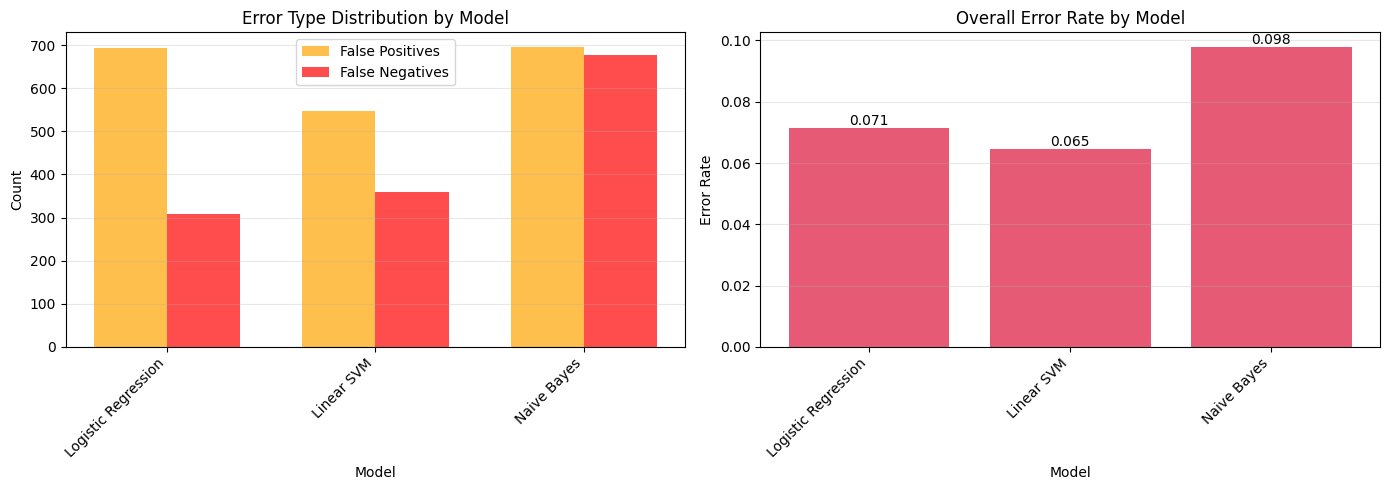

Saved: /media/relive/37c3bf4d-5cdc-450a-a045-97d5f9bc78961/project_z/outputs/ml_based/error_analysis.png


In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

model_names = error_df['Model']
x = np.arange(len(model_names))
width = 0.35

axes[0].bar(x - width/2, error_df['False_Positives'], width, 
           label='False Positives', color='orange', alpha=0.7)
axes[0].bar(x + width/2, error_df['False_Negatives'], width,
           label='False Negatives', color='red', alpha=0.7)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Count')
axes[0].set_title('Error Type Distribution by Model')
axes[0].set_xticks(x)
axes[0].set_xticklabels(model_names, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(model_names, error_df['Error_Rate'], color='crimson', alpha=0.7)
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Error Rate')
axes[1].set_title('Overall Error Rate by Model')
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(error_df['Error_Rate']):
    axes[1].text(i, v, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print(f'Saved: {OUTPUT_DIR}/error_analysis.png')

## 17. Classification Reports

In [20]:
for model_name, preds in predictions.items():
    report = classification_report(
        preds['y_test'], 
        preds['y_pred'],
        target_names=['Non-Toxic', 'Toxic'],
        output_dict=True
    )
    
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(f'{OUTPUT_DIR}/{model_name.replace(" ", "_")}_classification_report.csv')
    
    print(f'\n{model_name}:')
    print(classification_report(preds['y_test'], preds['y_pred'], 
                               target_names=['Non-Toxic', 'Toxic']))


Logistic Regression:
              precision    recall  f1-score   support

   Non-Toxic       0.95      0.90      0.93      7016
       Toxic       0.91      0.96      0.93      7016

    accuracy                           0.93     14032
   macro avg       0.93      0.93      0.93     14032
weighted avg       0.93      0.93      0.93     14032


Linear SVM:
              precision    recall  f1-score   support

   Non-Toxic       0.95      0.92      0.93      7016
       Toxic       0.92      0.95      0.94      7016

    accuracy                           0.94     14032
   macro avg       0.94      0.94      0.94     14032
weighted avg       0.94      0.94      0.94     14032


Naive Bayes:
              precision    recall  f1-score   support

   Non-Toxic       0.90      0.90      0.90      7016
       Toxic       0.90      0.90      0.90      7016

    accuracy                           0.90     14032
   macro avg       0.90      0.90      0.90     14032
weighted avg       0.90  